# Image Segmentation in Space Applications

## Use Case: Mound Classification in DTMs from Mars Arabia Terra.


In [3]:
%pylab inline
#Geo-libraries
from osgeo import gdal
import rasterio
import rasterio as rio
from rasterio.plot import show
import rasterio.plot as rplot
import earthpy.spatial as es
from rasterio.plot import show
from rasterio import mask
import osgeo
from osgeo import osr
import richdem as rd
#import gdal
#import elevation 
import geopandas as gpd
from rasterio.windows import Window


#visualisation
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image

#matrix computation/ML
import numpy as np
import segmentation_models_pytorch as smp
import torch
import subprocess
import albumentations as albu
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from sklearn.metrics import confusion_matrix

#for normalising
from sklearn.preprocessing import MinMaxScaler

#utils
import os
from pathlib import Path
import shutil
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch import FloatTensor
import warnings
import copy
warnings.simplefilter(action = 'ignore', category = FutureWarning)



Populating the interactive namespace from numpy and matplotlib


### Load Data

In [2]:
dem_path = 'training_site/DEM/Low-res_DEM/'
file_path = dem_path + "Firsoff_HiRISE_5_low_res.tif-adj.tif"
gdal_data = gdal.Open(file_path)

#load raster
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# convert to a numpy array
data_array=[]
data_array = gdal_band.ReadAsArray().astype(np.float64)
# data_array

# replace missing values if necessary
if np.any(data_array == nodataval):
    data_array[data_array == nodataval] = np.nan

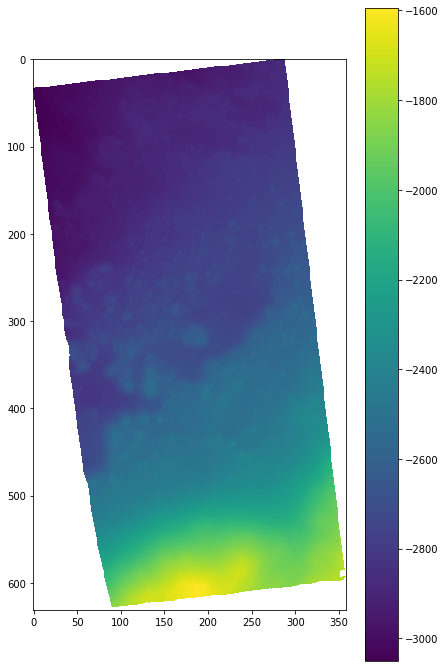

In [3]:
plt.figure(figsize = (7, 12))
plt.imshow(data_array)
plt.colorbar()
plt.show()

### Plot out data with Matplotlib's 'contour'


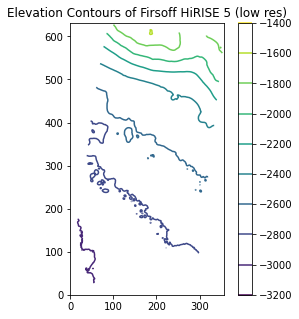

In [4]:

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
plt.contour(data_array)
plt.title("Elevation Contours of Firsoff HiRISE 5 (low res)")
cbar = plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()

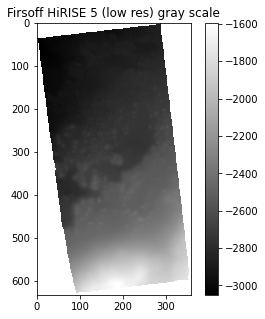

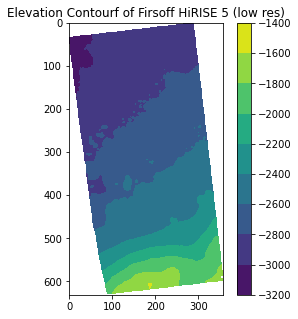

In [5]:
#Plot image in grayscale
plt.figure(figsize=(5,5))
plt.imshow(data_array, cmap = 'gray')
plt.colorbar()
plt.title("Firsoff HiRISE 5 (low res) gray scale")
plt.show()


#Plot a contourf graph
plt.figure(figsize=(5,5))
plt.title("Elevation Contourf of Firsoff HiRISE 5 (low res)")
plt.contourf(data_array)
plt.colorbar()
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()


In [6]:
dem = gdal.Open(file_path)
slp = gdal.DEMProcessing(dem_path + "slope.tif", dem, "slope", computeEdges=True)

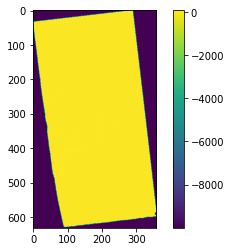

In [7]:
slparray = slp.GetRasterBand(1).ReadAsArray()

# Don't use matplotlib to visualize the slope
# Use richdem as shown below
plt.figure()
plt.imshow(slparray)
plt.colorbar()
plt.show()

### Creating a Hillshade : technique where a lighting effect is added to a map based on elevation variations within the landscape.


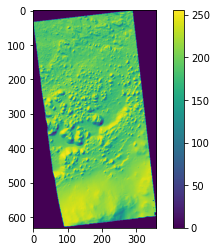

In [8]:
hillshade = gdal.DEMProcessing(dem_path + "hillshade1.tif", dem, "hillshade")
hillshade_array = hillshade.GetRasterBand(1).ReadAsArray()

plt.figure()
plt.imshow(hillshade_array)
plt.colorbar()
plt.show()

### Visualise slope:  identifies the steepness at each cell of a raster surface



A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.00775209


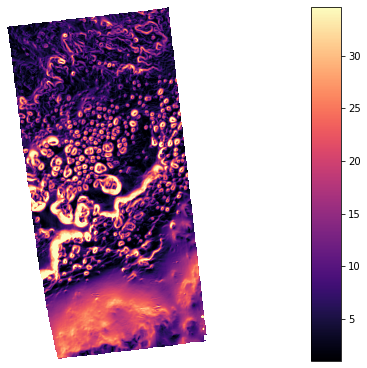

In [9]:
rd_dem = rd.LoadGDAL(file_path)
rd_slope = rd.TerrainAttribute(rd_dem, attrib="slope_degrees")
rd.rdShow(rd_slope, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()

# To save the result
# rd.SaveGDAL("rd_slope.tif", rd_slope)


A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0103459


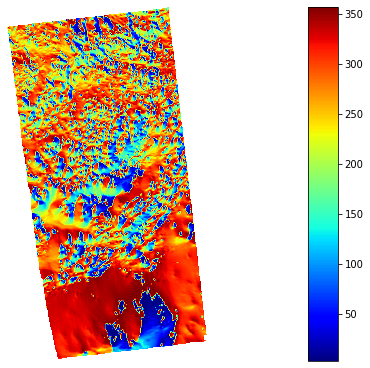

In [10]:
aspect = rd.TerrainAttribute(rd_dem, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8, 5.5))
plt.show()

In [11]:
dataset = gdal.Open(file_path)

# Getting som info about our DEM
print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                            dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

Driver: GTiff/GeoTIFF
Size is 358 x 632 x 1
Projection is PROJCS["unnamed",GEOGCS["Geographic Coordinate System",DATUM["D_MARS",SPHEROID["MARS",3396190,0]],PRIMEM["Reference Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Origin = (-534141.0, 135873.0)
Pixel Size = (18.0, -18.0)


In [12]:
# data_array_interp = np.interp(data_array, (-3200.0, -1400), (0, 255)).astype(np.uint8)
# plt.figure()
# plt.imshow(data_array_interp)
# plt.colorbar()
# plt.show()

In [4]:
### Data and label sources

mounds = '../training_site/mapping/polygons/mounds.shp'
dem = '../training_site/DEM/High-res_DEM/Firsoff_HiRISE_5.tif-adj.tif'
dem_lowres = '../training_site/DEM/Low-res_DEM/Firsoff_HiRISE_5_low_res.tif-adj.tif'
vents = "../training_site/mapping/points/vent_points.shp" 


### remove invalid shape geometries

mound_data = gpd.read_file(mounds)

toremove = []
for id, gg in enumerate(mound_data.geometry): # seems like we have some invalid geometries, dropping them
    if not gg.is_valid:
        print(f"not valid {id}")
        toremove.append(id)
        
mound_data = mound_data.drop(toremove)
mound_data.drop_duplicates(inplace=True)



not valid 56
not valid 92
not valid 100
not valid 163
not valid 200
not valid 329
not valid 330


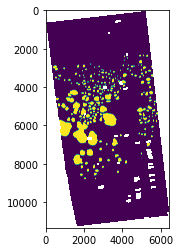

In [5]:

### Loading DEM source.
dsource= rio.open(dem)
dtm = dsource.read()
meta = dsource.meta
### Reprojecting the labels coordinate system to that of the original DEM.
mounds_corrected  = mound_data.to_crs(meta['crs'])
### Masking the labels. 0 for non mounds, 1 for mounds. Can be used for segmentation.
out_img, out_transform = mask.mask(dataset=dsource, shapes = mounds_corrected.geometry, nodata=np.nan) # do the crop
out_img = out_img[0]
nodata = meta["nodata"]
invalid_elevation = dtm[0] == nodata
isnan = np.isnan(out_img)
out_img[isnan] = 0
out_img[~isnan] = 1
out_img[invalid_elevation] = np.nan
# overall mask 0 non mounds, 1 mounds, np.nan unknown
figure()
imshow(out_img)


### Split the image into tiles
### GDAL implementation

In [6]:
def get_extent(dataset):

    cols = dataset.RasterXSize
    rows = dataset.RasterYSize
    transform = dataset.GetGeoTransform()
    minx = transform[0]
    maxx = transform[0] + cols * transform[1] + rows * transform[2]

    miny = transform[3] + cols * transform[4] + rows * transform[5]
    maxy = transform[3]

    return {
            "minX": str(minx), "maxX": str(maxx),
            "minY": str(miny), "maxY": str(maxy),
            "cols": str(cols), "rows": str(rows)
            }

def create_tiles(minx, miny, maxx, maxy, n):
    width = maxx - minx
    height = maxy - miny

    matrix = []

    for j in range(n, 0, -1):
        for i in range(0, n):

            ulx = minx + (width/n) * i # 10/5 * 1
            uly = miny + (height/n) * j # 10/5 * 1

            lrx = minx + (width/n) * (i + 1)
            lry = miny + (height/n) * (j - 1)
            matrix.append([[ulx, uly], [lrx, lry]])

    return matrix

def split(file_name, n):
    raw_file_name = os.path.splitext(os.path.basename(file_name))[0].replace("_downsample", "")
    driver = gdal.GetDriverByName('GTiff')
    dataset = gdal.Open(file_name)
    band = dataset.GetRasterBand(1)
    transform = dataset.GetGeoTransform()

    extent = get_extent(dataset)
    cols = int(extent["cols"])
    rows = int(extent["rows"])

    minx = float(extent["minX"])
    maxx = float(extent["maxX"])
    miny = float(extent["minY"])
    maxy = float(extent["maxY"])

    width = maxx - minx
    height = maxy - miny

    output_path = os.path.join("data", raw_file_name)
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    #print("GCD", gcd(round(width, 0), round(height, 0)))
    print("Width", width)
    print("height", height)


    tiles = create_tiles(minx, miny, maxx, maxy, n)
    transform = dataset.GetGeoTransform()
    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = -transform[5]

    #print(xOrigin, yOrigin)

    tile_num = 0
    ds = []
    for tile in tiles:

        minx = tile[0][0]
        maxx = tile[1][0]
        miny = tile[1][1]
        maxy = tile[0][1]

        p1 = (minx, maxy)
        p2 = (maxx, miny)

        i1 = int((p1[0] - xOrigin) / pixelWidth)
        j1 = int((yOrigin - p1[1])  / pixelHeight)
        i2 = int((p2[0] - xOrigin) / pixelWidth)
        j2 = int((yOrigin - p2[1]) / pixelHeight)

        #print(i1, j1)
        #print(i2, j2)

        new_cols = i2-i1
        new_rows = j2-j1

        data = band.ReadAsArray(i1, j1, new_cols, new_rows)

        #print data

        new_x = xOrigin + i1*pixelWidth
        new_y = yOrigin - j1*pixelHeight

        #print(new_x, new_y)

        new_transform = (new_x, transform[1], transform[2], new_y, transform[4], transform[5])

        output_file_base = raw_file_name + "_" + str(tile_num) + ".tif"
        output_file = os.path.join("data", raw_file_name, output_file_base)

        dst_ds = driver.Create(output_file,
                               new_cols,
                               new_rows,
                               1,
                               gdal.GDT_Float32)

        #writting output raster
        dst_ds.GetRasterBand(1).WriteArray(data)

        tif_metadata = {
            "minX": str(minx), "maxX": str(maxx),
            "minY": str(miny), "maxY": str(maxy)
        }
        dst_ds.SetMetadata(tif_metadata)

        #setting extension of output raster
        # top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution
        dst_ds.SetGeoTransform(new_transform)

        wkt = dataset.GetProjection()

        # setting spatial reference of output raster
        srs = osr.SpatialReference()
        srs.ImportFromWkt(wkt)
        dst_ds.SetProjection( srs.ExportToWkt() )
     
        ds.append(dst_ds)
    return ds
        #Close output raster dataset
#         dst_ds = None

#         tile_num += 1
    
    dataset = None


In [7]:
def tilize(dem_source, n):
    out = split(dem_source, n)
    for i in range(len(out)):
        ds_richdem = rd.rdarray(out[i].GetRasterBand(1).ReadAsArray(), no_data = meta['nodata'])
        driver = gdal.GetDriverByName('GTiff')
        driver.CreateCopy("tiles/{}.tif".format(i), out[i], 0)

### Rasterio implementation

In [ ]:
with rio.open(dem) as src:
    i = 0
    for ji, window in src.block_windows(1):
        r = src.read(window = window, masked = False)
        print(r.shape)
        rio.plot.show(r)
        kwargs = src.meta.copy()
        kwargs.update({
        "driver": "GTIff",
        'height': window.height,
        'width': window.width,
        'transform': rio.windows.transform(window, src.transform)})
        if not os.path.exists('tiles/'):
            os.makedirs('tiles/')
        
        if r.shape == (1,256,256):
            with open('tiles/tile_{}.npy'.format(i), 'wb') as f:
                np.save(f, src.read(window=window))
            with rio.open('tiles/tile_{}.tif'.format(i), 'w', **kwargs) as dst:
                 dst.write(src.read(window=window))
            i += 1




### Annotation script

In [ ]:
def numbers(s):
    return int(re.search(r"\d+", s).group(0))


for file in os.listdir('tiles'):
    if file.endswith('.tif'):
        fn = numbers(str(file))
        dsource= rio.open('tiles/{}'.format(file))
        dtm = dsource.read()
        meta = dsource.meta
        out_img, out_transform = mask.mask(dataset=dsource, shapes = mounds_corrected.geometry, crop = False) 
        out_img = out_img[0]
        nodata = meta["nodata"]
        invalid_elevation = dtm[0] == nodata
        isnan = np.isnan(out_img)
        out_img[isnan] = 0
        out_img[~isnan] = 1
        out_img[invalid_elevation] = np.nan
        # overall mask 0 non mounds, 1 mounds, np.nan unknown
        figure()
        imshow(out_img)
        
            
        if not os.path.exists('labels/'):
            os.makedirs('labels/')

        out = np.expand_dims(out_img, axis = 0)
        with open('labels/tile_{}.npy'.format(fn), 'wb') as f:
                np.save(f, out)
        kwargs = meta.copy()
        with rio.open('labels/tile_{}.tif'.format(fn), 'w', **kwargs) as dst:
             dst.write(out)
  




Data Cache contains 3 channel feature sets already created 

In [10]:
# Root Directory
Image_Path = 'data_cache/'
# Inputs/Sources
dataframes_path = Image_Path + "DataFrames/"
dataset_dirs_path = dataframes_path + 'three_channel_dataset.csv'

In [21]:
import albumentations
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch import FloatTensor


class Dataset(BaseDataset):    
    CLASSES = ['non-mound', 'mound']
    
    def __init__(
          self, 
          dirs,
          classes=None,
          augmentation=None):
        self.df = pd.read_csv(dirs)
        self.ids = self.df.index.to_list()

        ### convert str names to class values on masks
        self.class_values = CLASSES = [0, 1]
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        ### read data
        if self.df.at[i, 'origin'][-3:] == 'tif':
            ### load DEM
            with rasterio.open(self.df.at[i, 'origin']) as dem:
                dem_array = dem.read(1)
            ### load hillshade
            with rasterio.open(self.df.at[i, 'hillshade']) as hillshade:
                hillshade_array = hillshade.read(1)
            ### load slope
            with rasterio.open(self.df.at[i, 'slope']) as slope:
                slope_array = slope.read(1)
            ### load mask label
            with rasterio.open(self.df.at[i, 'mask']) as mask:
                mask_array = mask.read(1)
            mask_array = np.where(mask_array == 0.5, 0, mask_array)
            # apply augmentations
            if self.augmentation:
                ### only reshaping, so applying each function separately is ok.
                sample1 = self.augmentation(image=dem_array)
                dem_array= sample1['image']

                sample2 = self.augmentation(image=slope_array)
                slope_array = sample2['image']           

                sample3 = self.augmentation(image=hillshade_array)
                hillshade_array = sample3['image']

            input_array = [dem_array, slope_array, hillshade_array]
            input_array = np.stack(input_array, axis=0).astype('float')
            input_array = FloatTensor(input_array)
            mask_array = FloatTensor(np.expand_dims(mask_array,axis=(0)))
        
        elif self.df.at[i, 'origin'][-3:] == 'jpg':
            ###load the image and corresponding mask label
            image = Image.open(self.df.at[i, 'origin'])
            mask = Image.open(self.df.at[i, 'mask']).convert('L')
            
            ###convert image to numpy array
            input_array = np.asarray(image)
            input_array.transpose(2, 0, 1).astype('float32')
            mask_array = np.asarray(mask)
            mask_array = scaler.fit_transform(mask_array)
            mask_array = mask_array[ : ,0]            
            input_array = np.resize(input_array, (3, 224, 192))
            mask_array = np.resize(input_array, (224, 192))
            mask_array [mask_array >= 0.5] = 1 
            mask_array [mask_array < 0.5] = 0
            mask_array = FloatTensor(np.expand_dims(mask_array,axis=(0)))    
            input_array = FloatTensor(input_array)

        return input_array, mask_array
      
    def __len__(self):
        return len(self.ids)

In [22]:
### Sample reshaping (X,Y) --> (224,192)
def get_training_augmentation():
    train_transform = [albumentations.PadIfNeeded(min_height=224, min_width=192, always_apply=True, border_mode=0)]

    return albumentations.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albumentations.PadIfNeeded(224, 192)
    ]
    return albumentations.Compose(test_transform)

In [23]:
!ls data_cache/Annotated\ Tiles\ Sets/

'16x32 Tiles'  '32x64 Tiles'  '4x8 Tiles'
'2x4 Tiles'    '3x6 Tiles'    '8x16 Tiles'


In [19]:
ENCODER = 'se_resnext50_32x4d'
# ENCODER = 'resnet18'
### use imagenet weights
ENCODER_WEIGHTS = 'imagenet' 
# ENCODER_WEIGHTS = 'ssl'
### Sigmoid activation to obtain logits in final layer
ACTIVATION = 'sigmoid' 
CLASSES = [1, 0]
### altenative UNET instead of FPN
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=None, #ENCODER_WEIGHTS, 
    classes=1, 
    in_channels=3,
    activation=ACTIVATION)

In [24]:
#train_dirs_path = 'data_cache/DataFrames/three_channel_train.csv'
### Uncomment to exclude GAN images for training
CLASSES = [1, 0]

train_dirs_path = 'data_cache/DataFrames/three_channel_train(NO GAN).csv'
validate_dirs_path = 'data_cache/DataFrames/three_channel_valid.csv'
test_dirs_path = 'data_cache/DataFrames/three_channel_test.csv'

train_dataset = Dataset(train_dirs_path,
                        augmentation=get_training_augmentation(),                         
                        classes=CLASSES)


valid_dataset = Dataset(validate_dirs_path,
                        augmentation=get_validation_augmentation(),                         
                        classes=CLASSES)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers = 8)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers = 8)

In [25]:
train_dataset[2][0].shape

torch.Size([3, 224, 192])

In [26]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-3),
])

optimizer.param_groups[0]['lr']


0.001

In [27]:
## utility fn to for updating learnt weights as per the scheduler.
def update_learning_rate(scheduler, optimizer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print('learning rate = %.7f' % lr)

### Define device for computation

In [28]:
device  = torch.device("cuda:0")

In [29]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model.to(device), 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model.to(device), 
    loss=loss, 
    metrics=metrics, 
    verbose=True,
)

In [ ]:
# train model for 100 epochs
train_loss=[]
valid_loss=[]
train_fscore=[]
valid_fscore=[]
min_loss = float("inf")
max_score = 0
state_not_changed = 0
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
#scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1,)
for i in range(0, 100):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_loss.append(train_logs['dice_loss'])
    valid_loss.append(valid_logs['dice_loss'])
    train_fscore.append(train_logs['fscore'])
    valid_fscore.append(valid_logs['fscore'])
    state_not_changed+=1
    scheduler1.step()
#     scheduler2.step()
    # do something (save model, change lr, etc.)
    if min_loss > valid_logs['dice_loss']:
        min_loss = valid_logs['dice_loss']
        torch.save(model, './best_loss_model.pth')
        print('best_loss_model saved!')
        state_not_changed = 0
        
    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, './best_score_model.pth')
        print('best_score_model saved!')
        state_not_changed = 0
    
    
    if i % 10 == 0 and i != 0:
        print('Current learning rate = '+str(optimizer.param_groups[0]['lr'])+'!')
#         optimizer.param_groups[0]['lr'] /= 10
#         print('Decrease decoder learning rate to '+str(optimizer.param_groups[0]['lr'])+'!')
#         state_not_changed = 0
        
    if state_not_changed == 15:
        print('The model did not improve during the last 15 epochs')
        break

In [ ]:
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label = 'Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
with torch.no_grad():
            confusion_mat = []
            for sample in valid_loader:
            # get the inputs
                image = sample['image'].float()
                mask = sample['target_mask'].float()
                image = image.to(device)
                
                output = model(image)
                #probability_class = torch.exp(output) 
                prediction = torch.argmax(output,1).to("cpu")
                y_true = torch.argmax(mask,1).to("cpu")
              
                cm = confusion_matrix(prediction.view(-1), y_true.view(-1))
                confusion_mat.append( cm)
                #print(' cm:{}'.format(cm))
                
                # performance metrics for the model
                score_accuracy = accuracy_score(prediction.view(-1), y_true.view(-1))
                report = classification_report(prediction.view(-1), y_true.view(-1)) 
                
                fpr, tpr, _ = roc_curve(prediction.view(-1), y_true.view(-1))
                roc_auc = auc(fpr,tpr)
                print('score_accuracy:{}'.format(score_accuracy))
                print('Receiver operating characteristic (ROC):{}'.format(roc_auc))
            


<AxesSubplot:>

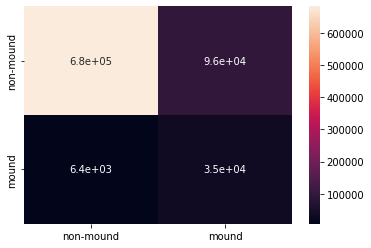

In [45]:
confusion_matrix = np.sum(confusion_mat,axis = 0)
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in ['non-mound', 'mound']],
                  columns = [i for i in ['non-mound','mound']])

import seaborn as sn
sn.heatmap(df_cm, annot = True,)

In [34]:
def predict_image(image):
    image_tensor = np.expand_dims(image,(2,3))
    #print(image_tensor.shape)
    image_tensor = np.transpose(image_tensor,(3,2,0,1))
    input = torch.from_numpy(image_tensor).to(device, dtype = torch.float)
    output = model(input)
    output = torch.argmax(output,1)
    index = output.float().to("cpu")
    return np.array(index)

def numbers(s):
    return int(re.search(r"\d+", s).group(0))

def reconstruct_map(tile_folder):
    fn_list = []
    for file in os.listdir(tile_folder):
        if file.endswith('.tif'):
            fn = numbers(str(file))
            fn_list.append(file)
    fn_list = np.sort(fn_list)
    sources = [rio.open(os.path.join(tile_folder,fn)) for fn in fn_list]
    merged_image, out_transform = merge(sources)
    return merged_image, out_transform

In [35]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(10, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [37]:
# test dataset without transformations for image visualization
test_dataset = Dataset(test_dirs_path, 
                           classes=CLASSES)


In [38]:
best_model = torch.load('FPN_3c_Without.pth')


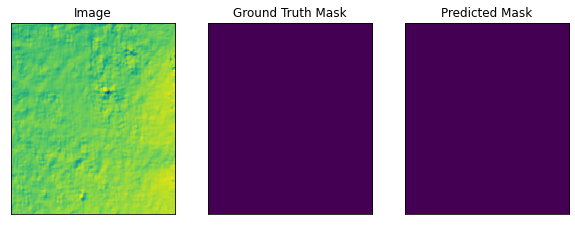

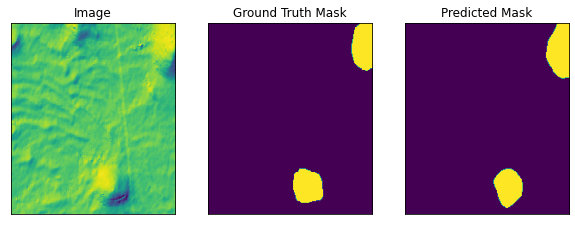

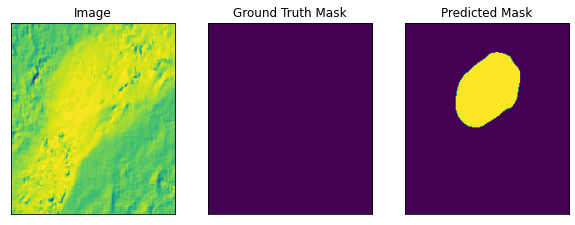

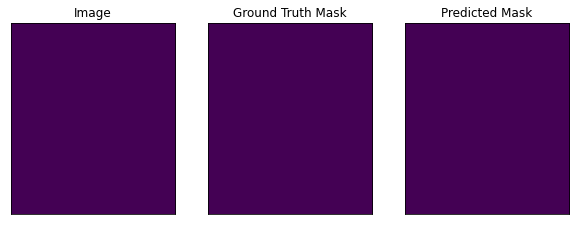

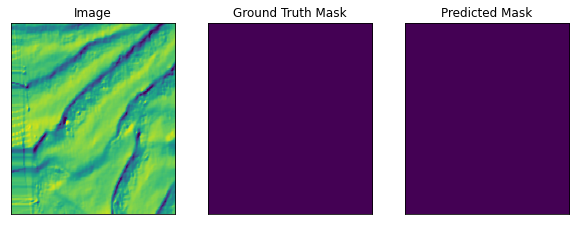

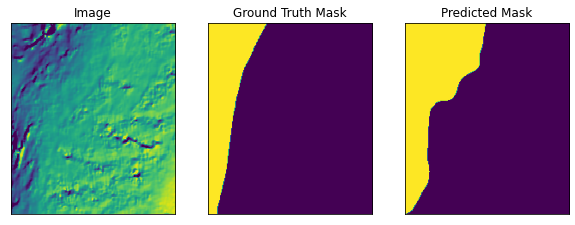

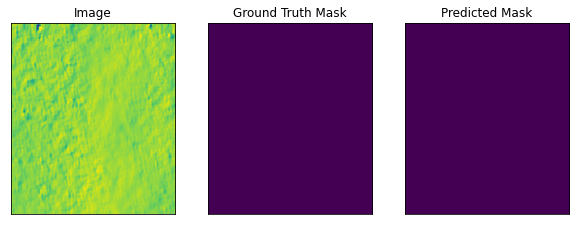

In [39]:
idx = [25, 30, 36, 38, 42, 53, 54]
#for i in range(len(test_dataset)):
for i in idx:
#     n = np.random.choice(len(test_dataset))
    n=i
    image_vis = test_dataset[n][0]
    image, gt_mask = test_dataset[n]
    
    x_tensor = image.unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis[2], 
        ground_truth_mask=gt_mask[0], 
        predicted_mask=pr_mask
    )

In [40]:
def recall(tp, fn):
    if tp+fn == 0:
        return 'invalid'
    return float(tp)/float(tp+fn)

def precision(tp, fp):
    if tp+fp == 0:
        return 'invalid'
    return float(tp)/float(tp+fp)

def f1_score(tp, fp, fn):
    if tp+fp+fn == 0:
        return 'invalid'
    return float(tp)/(tp + (float(fp + fn)/2))

def for_metric(fn, tn):
    if fn+tn == 0:
        return 'invalid'
    return float(fn)/(fn+tn)

In [ ]:
threshold = 0.5 ## Feel free to play around with the threshold value to find what works best
results = pd.DataFrame(columns=['id', 'tp', 'fp', 'tn', 'fn', 'precision', 'recall'])
# for i, sample in enumerate(test_dataset):
# idx = [75, 256, 269, 321, 406, 415, 504]
for i in range(len(test_dataset)):
    correct = 0
    sample = test_dataset[i]
    im = sample[0].unsqueeze(0).float()#.to(device)
    mask = sample[1].float()#.to(device)
    out = best_model(im).detach()
    #compute output class
    pred = out
    pred[out >= threshold] = 1
    pred[out < threshold] = 0
    correct += (pred == mask).sum().item()
    total = len(mask.view(-1))
    accuracy = float(correct/total)
#     tp, fp, fn, tn = smp.metrics.get_stats(out, mask, mode='binary', threshold=0.5)
    # Sklearn doc
    tn, fp, fn, tp = confusion_matrix(mask.view(-1), pred.view(-1), labels=[0., 1.]).ravel()
    
    tmp = pd.DataFrame(columns=['id', 'tp', 'fp', 'tn', 'fn', 'precision', 'recall'])
    tmp['id'] = [i]
    tmp['tp'] = [tp]
    tmp['fp'] = [fp]
    tmp['tn'] = [tn]
    tmp['fn'] = [fn]
    tmp['recall'] = [recall(tp=tp, fn=fn)]
    tmp['precision'] = [precision(tp=tp, fp=fp)]
    results = results.append(tmp)

In [42]:
ttp = np.sum(results['tp'].values)
tfp = np.sum(results['fp'].values)
ttn = np.sum(results['tn'].values)
tfn = np.sum(results['fn'].values)

In [43]:

print(f'tp = {ttp}, fp = {tfp}, tn={ttn}, fn ={tfn}, precision = {precision(tp=ttp, fp=tfp)}, recall = {recall(tp=ttp, fn=tfn)} ')
print(f'F-Score = {f1_score(tp= ttp, fp= tfp, fn= tfn)}')

tp = 1291642, fp = 384376, tn=16219260, fn =297106, precision = 0.7706611742833311, recall = 0.8129936276867068 
F-Score = 0.7912616095609915
